5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.
6. Visualize at least 5 different samples of the MNIST training dataset.
7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.
8. Recreate `model_2` used in this notebook (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.
9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.
10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.
11. Plot a confusion matrix comparing your model's predictions to the truth labels.
12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?
13. Use a model similar to the trained `model_2` from this notebook to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 

In [2]:
import torch
import pandas as pd
import os
from torchvision.datasets import MNIST
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


### Создаем DataLoader'ы

In [3]:
mnist_train = MNIST('~/mist_data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('~/mist_data', train=False, download=True, transform=transforms.ToTensor())


train_dl = DataLoader(mnist_train, shuffle=True, batch_size=32)
test_dl = DataLoader(mnist_test, shuffle=False, batch_size=32)

class_names = mnist_test.classes

### Putting datasets into Pandas df to check

In [4]:
train_dict = {
    "labels" : []
}

test_dict = {
    "labels" : []
}

for batch, (img, labels) in enumerate(train_dl):
    for i in range(len(labels)):
        train_dict["labels"].append(labels.numpy()[i])
        
for batch, (img, labels) in enumerate(test_dl):
    for i in range(len(labels)):
        test_dict["labels"].append(labels.numpy()[i])

train_df = pd.DataFrame.from_dict(train_dict)
test_df = pd.DataFrame.from_dict(test_dict)

In [5]:
train_df.describe()

labels
count  60000.000000
mean       4.453933
std        2.889270
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max        9.000000

In [6]:
test_df.describe()

labels
count  10000.000000
mean       4.443400
std        2.895865
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max        9.000000

### Создаем модель

In [7]:
class model_V0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, num_classes: int):
        super().__init__()
        
        self.relu = nn.ReLU()
        
        
        # Block 1
        self.conv_1_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding="same")
        # ReLU
        self.conv_1_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding="same")
        # ReLU
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Block 2
        self.conv_2_1 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding="same")
        # ReLU
        self.conv_2_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding="same")
        # ReLU
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Classificator
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=hidden_units*7*7, out_features=num_classes)


    def forward(self, x):
        
        # Block 1
        x = self.conv_1_1(x)
        x = self.relu(x)
        x = self.conv_1_2(x)
        x = self.relu(x)
        x = self.max_pool_1(x)
        
        # Block 2
        x = self.conv_2_1(x)
        x = self.relu(x)
        x = self.conv_2_2(x)
        x = self.relu(x)
        x = self.max_pool_2(x)
        
        # Classificator
        x = self.flatten(x)
        x = self.linear(x)
        
        return x



### Тестируем модель

In [8]:
model = model_V0(1, 10, 10).to(device)


with torch.inference_mode():
    for batch, (imgs, labels) in enumerate(train_dl):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # print(f"imgs shape = {imgs.shape}")
        # print(f"labels shape = {labels.shape}")
        
        logits = model(imgs).to(device)
        soft_preds = torch.softmax(logits, dim=1)
        preds = torch.argmax(soft_preds, dim=1)
        print(f"logits shape = {logits.shape}")
        print(f"soft_preds shape = {soft_preds.shape}")
        print(f"preds shape = {preds.shape}")
        
        
        # for i in range(len(labels)):
        print(f"Prediction: {preds}")
        print(f"Label: {labels}")
        # if batch == 5:
        break


logits shape = torch.Size([32, 10])
soft_preds shape = torch.Size([32, 10])
preds shape = torch.Size([32])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor([2, 6, 8, 9, 1, 4, 0, 4, 5, 2, 1, 6, 5, 3, 4, 2, 9, 4, 8, 7, 9, 0, 9, 2,
        4, 5, 2, 6, 4, 0, 2, 1])


### Model saving function

In [9]:
def save_checkpoint(state, filename='./checkpoint.pth.tar'):
    if os.path.isfile(filename):
        os.remove(filename)
    torch.save(state, filename)

### Теперь функции train и test step


In [10]:
def train_step(model, train_dl: DataLoader, optimizer, loss_fn):
    model.train()
    loss_var = 0
    acc = 0 
    num_elements = len(train_dl) * 32
        
    for batch, (imgs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs).to(device)
        
        # print(f"logits device: {logits.device}\nlabels device: {labels.device}")
        
        loss = loss_fn(logits, labels)
        loss_var += loss
        loss.backward()
        optimizer.step()
        train_soft_preds = torch.softmax(logits, dim=1)
        train_preds = torch.argmax(train_soft_preds, dim=1)
            
        for i in range(len(train_preds)):
            acc += train_preds[i] == labels[i]
        print(f"Train step progress: {(batch + 1) / len(train_dl)}")
        print(f"loss: {loss}\naccuracy: {acc / (32 * (batch + 1))}")
    return loss_var / num_elements, acc / num_elements

In [11]:
def test_step(model, test_dl, loss_fn):
    model.eval()
    
    loss = 0
    acc = 0    
    num_elements = len(test_dl) * 32
    
    with torch.inference_mode():
        for batch, (imgs, labels) in enumerate(test_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            logits = model(imgs).to(device)
            
            test_soft_preds = torch.softmax(logits, dim=1)
            test_preds = torch.argmax(test_soft_preds, dim=1)
            
            
            
            loss += loss_fn(logits, labels)
            
            for i in range(len(test_preds)):
                acc += test_preds[i] == labels[i]
            print(f"Test step progress: {(batch + 1) / len(test_dl)}")
            print(f"loss: {loss / (32 * (batch + 1))}\naccuracy: {acc / (32 * (batch + 1))}")
            
            
            
        return loss.to("cpu") / num_elements, acc / num_elements
    

### Train-test loop

In [14]:
EPOCHS = 6
load_model = True
save_model = False
train = False

path_to_model_checkpoint = "/home/leevroko/Vaults/Obsidian/Programming_tests/Pytorch/ZTM/image_classifier_v0.tar"


model = model_V0(1, 10, 10).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

training_epochs = 0
if (load_model):
    checkpoint = torch.load(path_to_model_checkpoint)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_epochs = checkpoint["training_epochs"]
    

# model = model_V0(1, 10, 10).to(device)
if (train):
    for epoch in range(EPOCHS):
        train_loss, train_accuracy = train_step(model, train_dl, optimizer, loss_fn)
        test_loss, test_accuracy = test_step(model, test_dl, loss_fn)
        print("\n\n")
        print(f"Train loss: {train_loss}\nTrain accuracy: {train_accuracy}")
        print(f"Test loss: {test_loss}\nTest accuracy: {test_accuracy}")
        print("\n\n")
    training_epochs += EPOCHS

if (save_model):
    save_checkpoint(
                    {
                        "state_dict": model.to("cpu").state_dict(),
                        "optimizer_state_dict" : optimizer.state_dict(),
                        "training_epochs": training_epochs,
                    },
                    path_to_model_checkpoint)


### Make predictions with my model

In [15]:
def predict(model, input_img):
    model.eval()
    if (len(input_img.shape) == 3):
        input_img = input_img.unsqueeze(dim=0)
    
    with torch.inference_mode():
        logits = model(input_img)
        soft_preds = torch.softmax(logits, dim=1)
        preds = torch.argmax(soft_preds, dim=1)
        
    return preds

In [17]:
test_img = None
test_label = None

acc = 0
for batch, (imgs, labels) in enumerate(train_dl):
    imgs = imgs.to(device)
    labels = labels.to(device)
    sum_acc = 0
    prediction = predict(model, imgs)
    for i in range(len(labels)):
        sum_acc += prediction[i] == labels[i]
        if (batch == 2 and i == 3):
            test_img = imgs[i]
            test_label = labels[i]
            break
        # print(f"prediction: {prediction[i]}\nlabel: {labels[i]}")
    acc = sum_acc / len(labels)

print(f"accuracy: {acc * 100}%")


accuracy: 100.0%


TESTING ON A PARTICULAR IMAGE
prediction is: tensor([3])


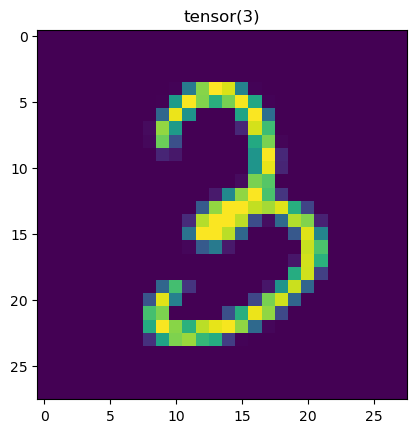

In [21]:

print(f"TESTING ON A PARTICULAR IMAGE")
plt.imshow(test_img.squeeze())
plt.title(test_label)
print(f"prediction is: {predict(model, test_img)}")


### Plotting confusion matrix

In [19]:
test_img = None
test_label = None

y_pred_tensor = []
targets = []

acc = 0
for batch, (imgs, labels) in enumerate(train_dl):
    imgs = imgs.to(device)
    labels = labels.to(device)
    sum_acc = 0
    prediction = predict(model, imgs)
    
    for i in range(len(prediction)):
        y_pred_tensor.append(prediction[i])
        targets.append(labels[i])
    
    for i in range(len(labels)):
        sum_acc += prediction[i] == labels[i]
        if (batch == 2 and i == 3):
            test_img = imgs[i]
            test_label = labels[i]
            break
        # print(f"prediction: {prediction[i]}\nlabel: {labels[i]}")
    acc = sum_acc / len(labels)

y_pred_tensor = torch.tensor(y_pred_tensor)
targets = torch.tensor(targets)


print(f"accuracy: {acc * 100}%")

accuracy: 93.75%


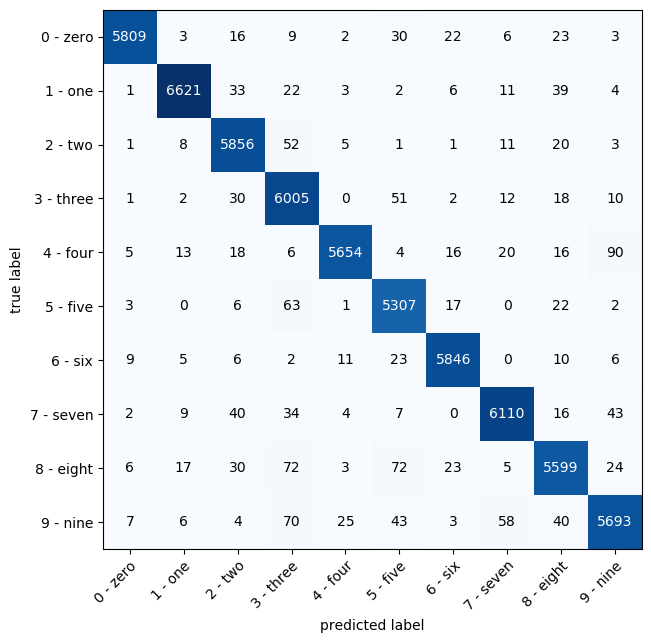

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);